# Visualise the leakage from terms
We want to know:
- how much leakage from constant terms appears in f1
- how much leakage from constant terms appears in f2 and are these equal
- how much leakage from constant terms appears in f12 and do these 3 sum to offset the constant term to the data mean
- how much leakage from first-order terms appear in f12

In [2]:
%run imports.py

seed = 4
np.random.seed(seed)
tf.random.set_seed(seed)

All packages loaded successfully.


In [3]:
# --- Generate synthetic 2D data ---
def true_function(X):
    x1, x2 = X[:,0], X[:,1]
    return np.sin(x1*2) + 3*x2**3 + x1*np.sin(x2*2)


# --- Define the true components ---
true_f1 = lambda x: np.sin(2*x)
true_f2 = lambda x: 3*x**3
true_f12 = lambda X: X[:,0]*np.sin(2*X[:,1])



n = 1000
noise = 0.01
X = np.random.normal(0, 1, size=(n,2))
y = true_function(X) + np.random.normal(0, noise, size=n)
y = y.reshape(-1, 1)
y_mean, y_std = np.mean(y), np.std(y)
y = (y - y_mean) / y_std

In [4]:
# --- Create AGP model ---
data = (X, y)
model = create_model_oak(
        data=data,
        max_interaction_depth=2,
        constrain_orthogonal=False,
        share_var_across_orders=True,
        use_sparsity_prior=False,
)

# --- Train model ---
opt = gpflow.optimizers.Scipy()
opt.minimize(model.training_loss, model.trainable_variables, options=dict(maxiter=1000, gtol=1e-8, ftol=1e-12, disp=True))

# --- Print model summary ---
gpflow.utilities.print_summary(model)

sigma0_opt = model.kernel.variances[0].numpy()
sigma1_opt = model.kernel.variances[1].numpy()
sigma2_opt = model.kernel.variances[2].numpy()
ls1_opt = model.kernel.kernels[0].lengthscales.numpy()
ls2_opt = model.kernel.kernels[1].lengthscales.numpy()
print(model.training_loss().numpy())

╒════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤════════════╕
│ name                               │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │      value │
╞════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪════════════╡
│ GPR.kernel.kernels[0].lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │   2.49306  │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────┤
│ GPR.kernel.kernels[1].lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │   1.54193  │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────┤
│ GPR.kernel.variances[0]            │ Parameter │ Softplus         │         │ True        │ ()      │ float64

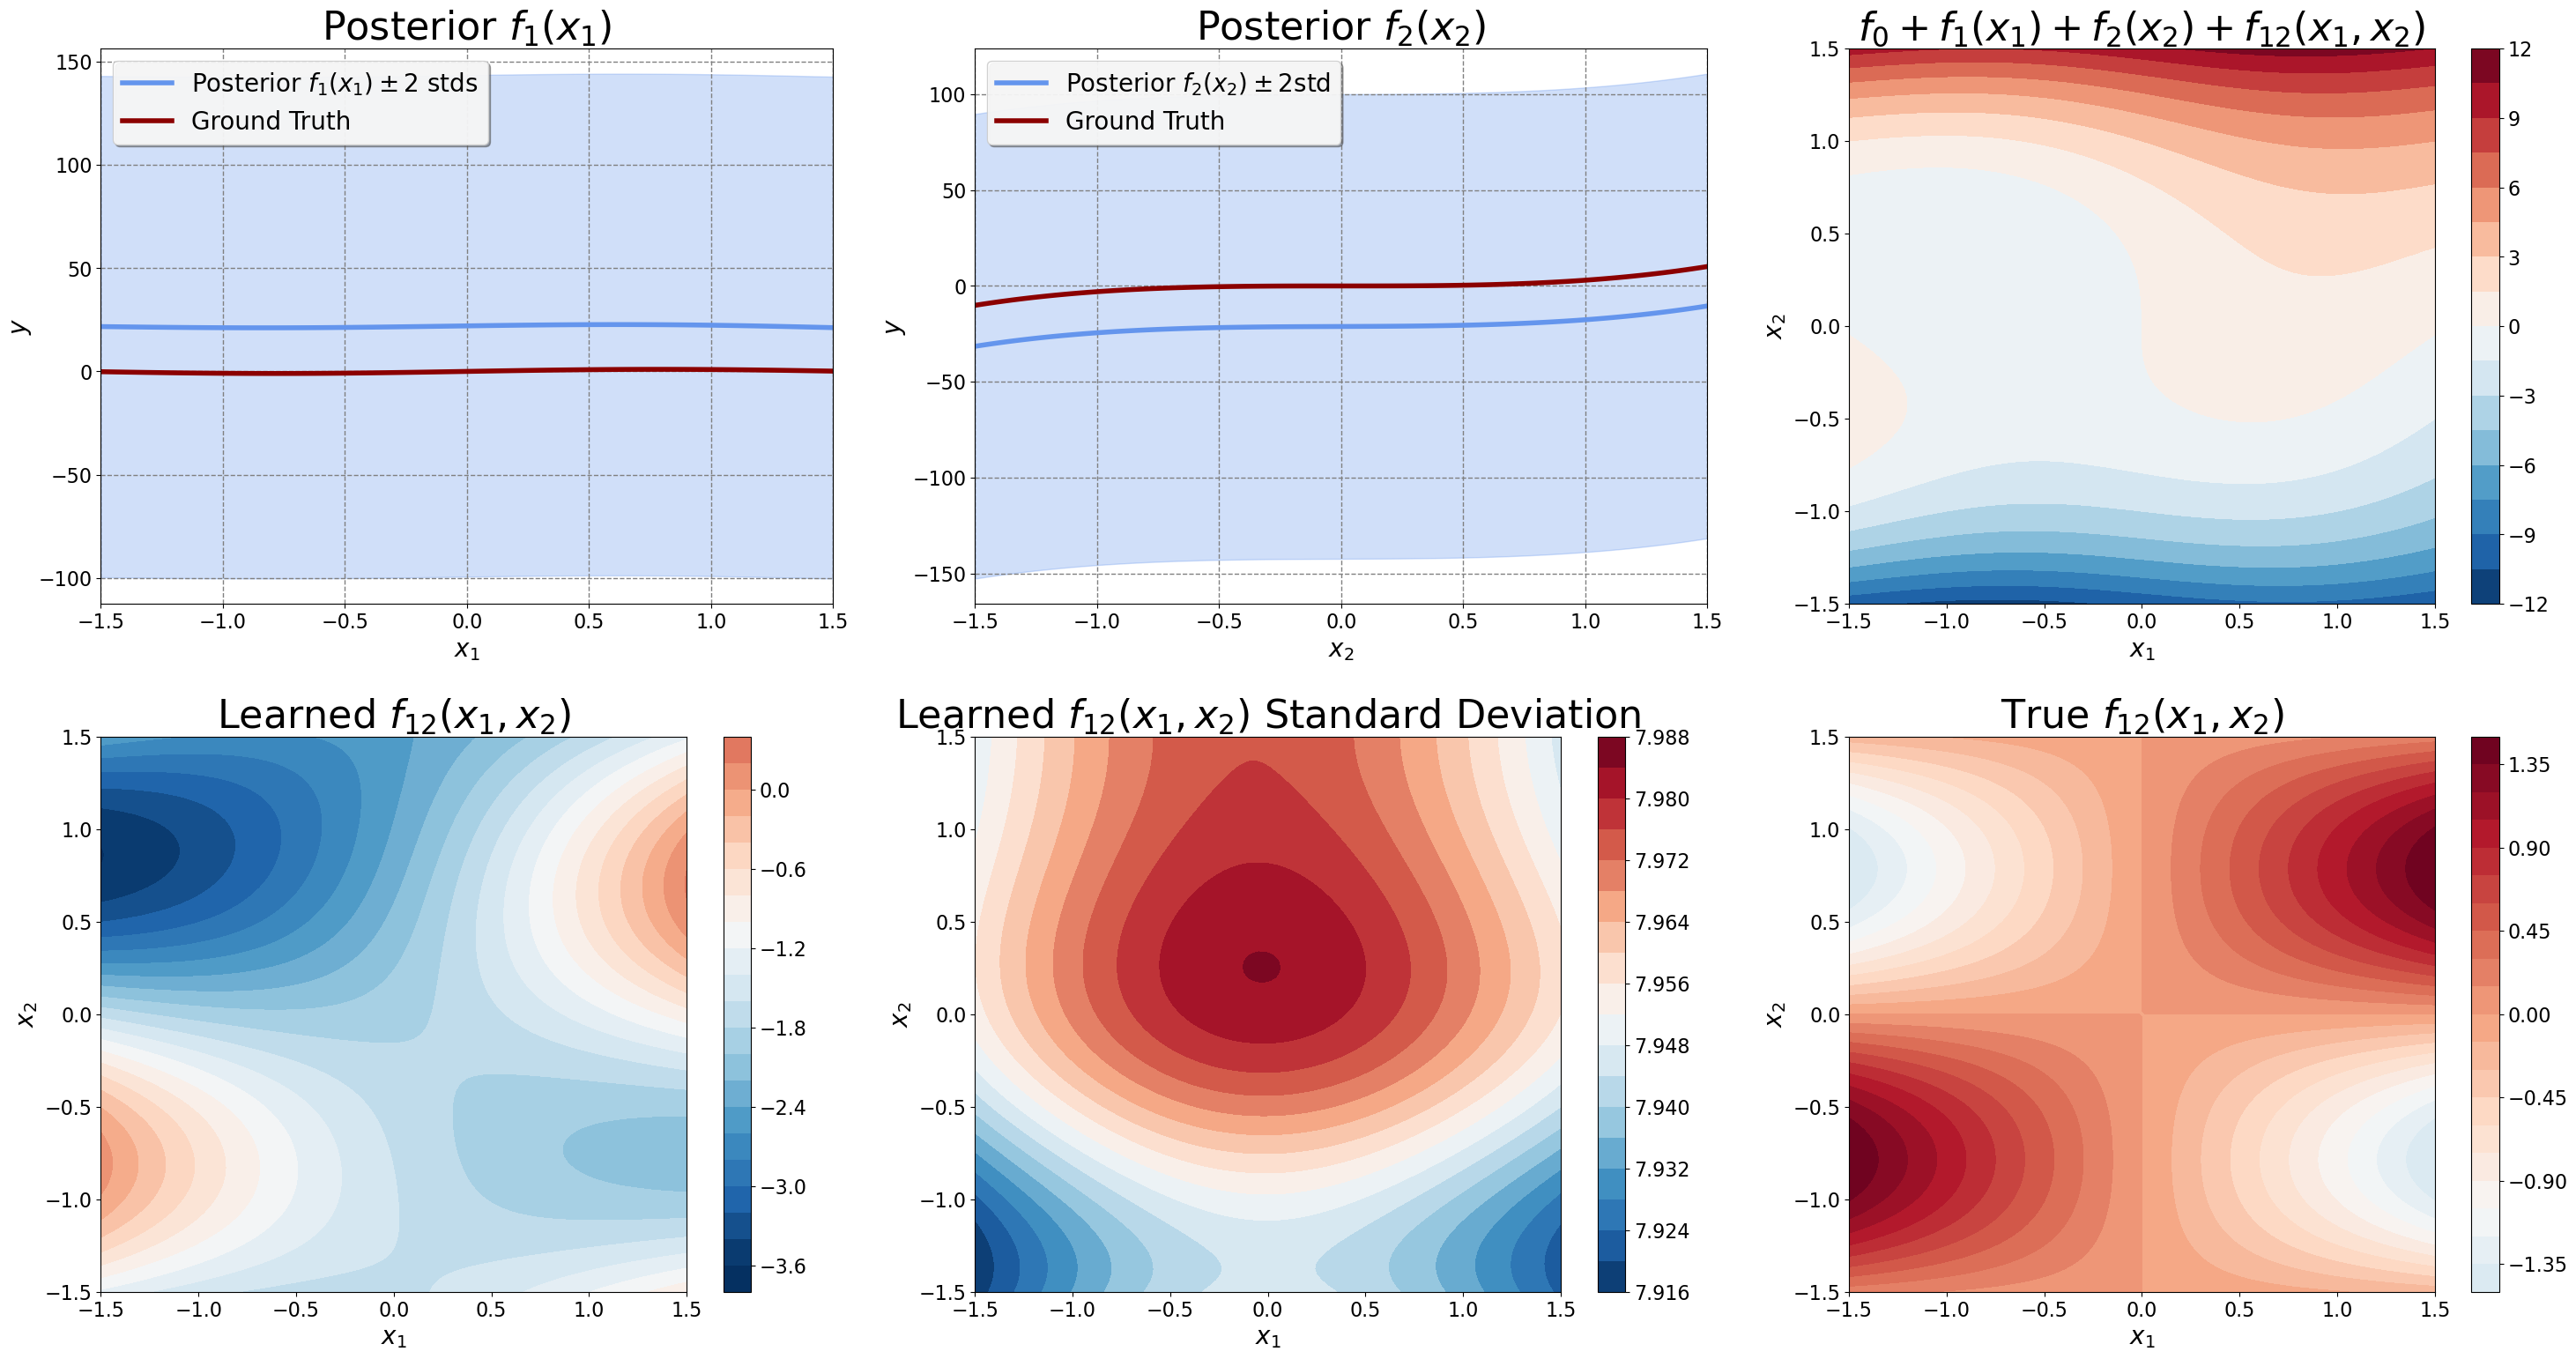

In [5]:
N = 10000
X_samples = np.random.normal(0, 1, size=(N, 2))
X_train = model.data[0].numpy()
alpha = get_model_sufficient_statistics(model, get_L=False)
selected_dims, kernel_list = get_list_representation(model.kernel, num_dims=2)



# --- Meshgrid for plotting ---
x1_plot = np.linspace(-1.5, 1.5, 100)
x2_plot = np.linspace(-1.5, 1.5, 100)
X1_grid, X2_grid = np.meshgrid(x1_plot, x2_plot)
X_grid = np.stack([X1_grid.ravel(), X2_grid.ravel()], axis=1)
X_grid_tf = tf.convert_to_tensor(X_grid, dtype=tf.float64)
X_grid_f1 = np.stack([X1_grid.ravel(), np.zeros_like(X1_grid).ravel()], axis=1)
X_grid_f1_tf = tf.convert_to_tensor(X_grid_f1, dtype=tf.float64)
X_grid_f2 = np.stack([np.zeros_like(X2_grid).ravel(), X2_grid.ravel()], axis=1)
X_grid_f2_tf = tf.convert_to_tensor(X_grid_f2, dtype=tf.float64)


# --- Build inputs with fixed variables for f1 and f2 ---
X_plot_f1 = np.copy(X_grid)
X_plot_f1[:, 1] = 0
X_plot_f2 = np.copy(X_grid)
X_plot_f2[:, 0] = 0
X_plot_f12 = X_grid


# --- Evaluate function ---
f0_vals = eval_component(kernel_list[0], alpha, tf.convert_to_tensor(X_plot_f12, dtype=tf.float64), tf.convert_to_tensor(X_train, dtype=tf.float64)).reshape(X1_grid.shape)
f1_vals = eval_component(kernel_list[1], alpha, tf.convert_to_tensor(X_plot_f1, dtype=tf.float64), tf.convert_to_tensor(X_train, dtype=tf.float64)).reshape(X1_grid.shape)
f2_vals = eval_component(kernel_list[2], alpha, tf.convert_to_tensor(X_plot_f2, dtype=tf.float64), tf.convert_to_tensor(X_train, dtype=tf.float64)).reshape(X1_grid.shape)
f12_vals = eval_component(kernel_list[3], alpha, tf.convert_to_tensor(X_plot_f12, dtype=tf.float64), tf.convert_to_tensor(X_train, dtype=tf.float64)).reshape(X1_grid.shape)


# --- Posterior Variances ---
K_yy = model.kernel.K(X_train, X_train) + tf.eye(len(X_train), dtype=tf.float64) * model.likelihood.variance.numpy()

# Variance for f0
var_f0_tensor = get_component_variance(kernel_list[0], K_yy, X_grid_tf, X_train)
var_f0 = var_f0_tensor.numpy().reshape(100, 100)
std_f0 = np.sqrt(var_f0) * y_std

# Variance for f1
var_f1_tensor = get_component_variance(kernel_list[1], K_yy, X_grid_f1_tf, X_train)
var_f1 = var_f1_tensor.numpy().reshape(100, 100)
std_f1 = np.sqrt(np.mean(var_f1, axis=0)) * y_std

# Variance for f2
var_f2_tensor = get_component_variance(kernel_list[2], K_yy, X_grid_f2_tf, X_train)
var_f2 = var_f2_tensor.numpy().reshape(100, 100)
std_f2 = np.sqrt(np.mean(var_f2, axis=0)) * y_std

# Variance for f12
var_f12_tensor = get_component_variance(kernel_list[3], K_yy, X_grid_tf, X_train)
var_f12 = var_f12_tensor.numpy().reshape(100, 100)
std_f12 = np.sqrt(var_f12) * y_std

# Variance for the overall model
var_overall_tensor = get_component_variance(model.kernel, K_yy, X_grid_tf, X_train)
var_overall = var_overall_tensor.numpy().reshape(100, 100)
std_overall = np.sqrt(var_overall) * y_std



# --- Denorrmalise ---
f_sum = (f0_vals + f1_vals + f2_vals + f12_vals) * y_std + y_mean
f0_vals = f0_vals * y_std + y_mean
f1_vals = f1_vals * y_std
f2_vals = f2_vals * y_std
f12_vals = f12_vals * y_std
f_true = true_function(X_grid).reshape(100,100)




# --- 1D plots of f1(x1), f2(x2) ---
f1_x1 = np.mean(f1_vals, axis=0)
f1_true = true_f1(x1_plot)
f2_x2 = np.mean(f2_vals, axis=1)
f2_true = true_f2(x2_plot)
f12_true = true_f12(X_grid).reshape(100,100)

f12_x1 = np.mean(f12_vals, axis=0)
f12_x2 = np.mean(f12_vals, axis=1)
f12_x1_true = np.mean(f12_true, axis=0)
f12_x2_true = np.mean(f12_true, axis=1)


# --- Plot the results ---
fig, axes = plt.subplots(2, 3, figsize=(30, 16))

# f1
axes[0, 0].plot(x1_plot, f1_x1, label='Posterior $f_1(x_1) \\pm 2$ stds', color='cornflowerblue', linewidth=4)
axes[0, 0].fill_between(x1_plot, f1_x1 - 2*std_f1, f1_x1 + 2*std_f1, color='cornflowerblue', alpha=0.3)
axes[0, 0].plot(x1_plot, f1_true, label='Ground Truth', color='darkred', linewidth=4)
axes[0, 0].set_title("Posterior $f_1(x_1)$")
axes[0, 0].set_xlabel('$x_1$')
axes[0, 0].set_ylabel('$y$')
axes[0, 0].set_xlim([-1.5,1.5])
axes[0, 0].grid(True)
axes[0, 0].legend(loc='upper left', frameon=True, shadow=True, fancybox=True, framealpha=0.9)


# f2
axes[0, 1].plot(x2_plot, f2_x2, label='Posterior $f_2(x_2) \\pm 2$std', color='cornflowerblue', linewidth=4)
axes[0, 1].fill_between(x2_plot, f2_x2 - 2*std_f2, f2_x2 + 2*std_f2, color='cornflowerblue', alpha=0.3)
axes[0, 1].plot(x2_plot, f2_true, label='Ground Truth', color='darkred', linewidth=4)
axes[0, 1].set_title("Posterior $f_2(x_2)$")
axes[0, 1].set_xlabel('$x_2$')
axes[0, 1].set_ylabel('$y$')
axes[0, 1].set_xlim([-1.5,1.5])
axes[0, 1].grid(True)
axes[0, 1].legend(loc='upper left', frameon=True, shadow=True, fancybox=True, framealpha=0.9)


# f_total
cont2 = axes[0, 2].contourf(X1_grid, X2_grid, f_sum, levels=20, cmap='RdBu_r')
axes[0, 2].set_title("$f_0 + f_1(x_1) + f_2(x_2) + f_{12}(x_1,x_2)$")
fig.colorbar(cont2, ax=axes[0, 2])
#axes[0, 2].set_xticks([])
#axes[0, 2].set_yticks([])
axes[0, 2].set_xlabel('$x_1$')
axes[0, 2].set_ylabel('$x_2$')


vmin = min(f12_vals.min(), f12_true.min())
vmax = max(f12_vals.max(), f12_true.max())


# Learned f12
cont = axes[1, 0].contourf(X1_grid, X2_grid, f12_vals, levels=20, cmap='RdBu_r', vmin=vmin, vmax=vmax)
axes[1, 0].set_title("Learned $f_{12}(x_1, x_2)$")
fig.colorbar(cont, ax=axes[1, 0])
#axes[1, 0].set_xticks([])
#axes[1, 0].set_yticks([])
axes[1, 0].set_xlabel('$x_1$')
axes[1, 0].set_ylabel('$x_2$')

# Interaction Standard Deviation
cont3 = axes[1, 1].contourf(X1_grid, X2_grid, std_f12, levels=20, cmap='RdBu_r')
axes[1, 1].set_title("Learned $f_{12}(x_1, x_2)$ Standard Deviation")
fig.colorbar(cont3, ax=axes[1, 1])
#axes[1, 1].set_xticks([])
#axes[1, 1].set_yticks([])
axes[1, 1].set_xlabel('$x_1$')
axes[1, 1].set_ylabel('$x_2$')


# True f12
cont = axes[1, 2].contourf(X1_grid, X2_grid, f12_true, levels=20, cmap='RdBu_r', vmin=vmin, vmax=vmax)
axes[1, 2].set_title("True $f_{12}(x_1, x_2)$")
fig.colorbar(cont, ax=axes[1, 2])
#axes[1, 2].set_xticks([])
#axes[1, 2].set_yticks([])
axes[1, 2].set_xlabel('$x_1$')
axes[1, 2].set_ylabel('$x_2$')




plt.tight_layout(pad=2.0)
plt.show()

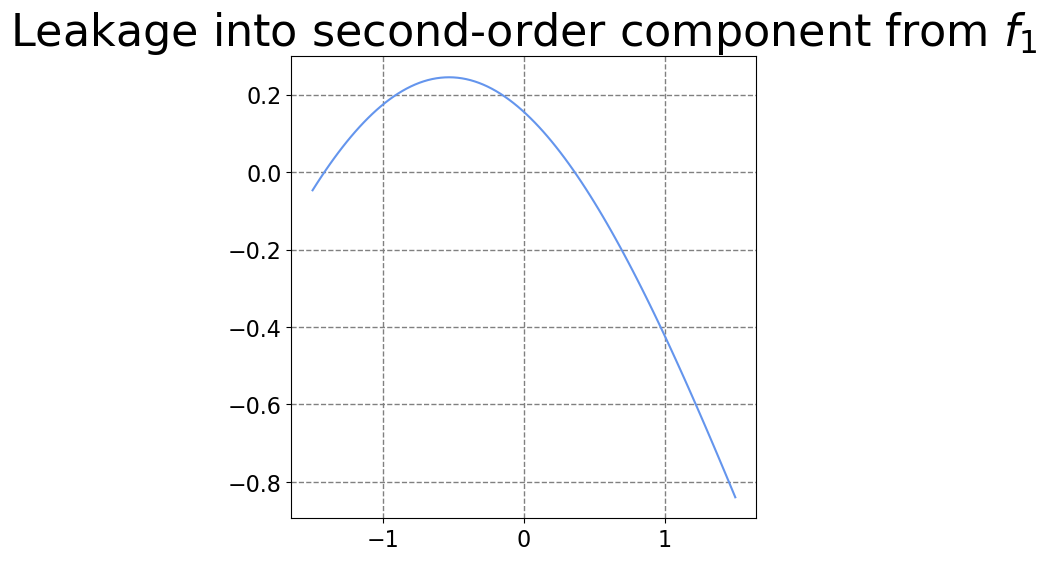

Leakage as a constant is 21.89993385494414


In [6]:
# --- Leakage from f1 into f12 ---
f1_const_leakage = f1_x1 - f1_true
x_values = np.linspace(-1.5,1.5,100)
pdf_weights = norm.pdf(x_values, loc=0, scale=1)
sum_of_weights = np.sum(pdf_weights)
f1_expectation = np.sum(f1_const_leakage * pdf_weights) / sum_of_weights
f1_norm_zero_centred = f1_const_leakage - f1_expectation

plt.figure(figsize=(6,6))
plt.plot(x_values, f1_norm_zero_centred, color='cornflowerblue')
plt.grid('on')
plt.title('Leakage into second-order component from $f_1$')
plt.show()

const_f1 = (f1_const_leakage - f1_norm_zero_centred)[0]
print(f"Leakage as a constant is {const_f1}")

The graph shows the difference between the true and predicted f1, centered at zero under a standard normal distribution, i.e. the terms that are in f1 which should be in f12.

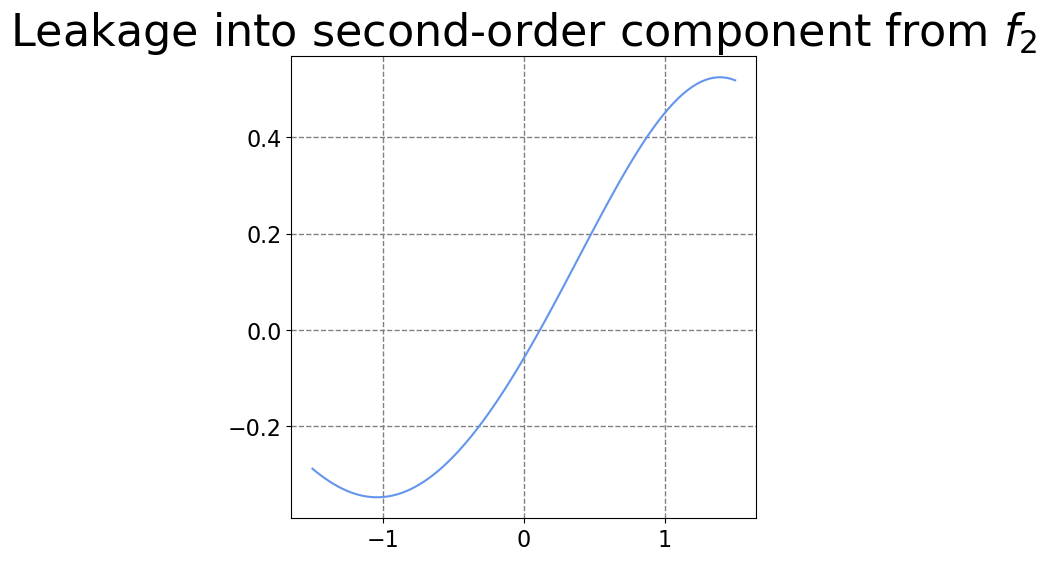

Leakage as a constant is -21.094637736205932


In [8]:
# --- Constant Leakage into f2 ---
f2_const_leakage = f2_x2 - f2_true
f2_expectation = np.sum(f2_const_leakage * pdf_weights) / sum_of_weights
f2_norm_zero_centred = f2_const_leakage - f2_expectation

plt.figure(figsize=(6,6))
plt.plot(x_values, f2_norm_zero_centred, color='cornflowerblue')
plt.grid('on')
plt.title('Leakage into second-order component from $f_2$')
plt.show()

const_f2 = (f2_const_leakage - f2_norm_zero_centred)[0]
print(f"Leakage as a constant is {const_f2}")

There looks to be a trade-off here but let's look closer...

Constant Leakage in first order component is 0.8052961187382088


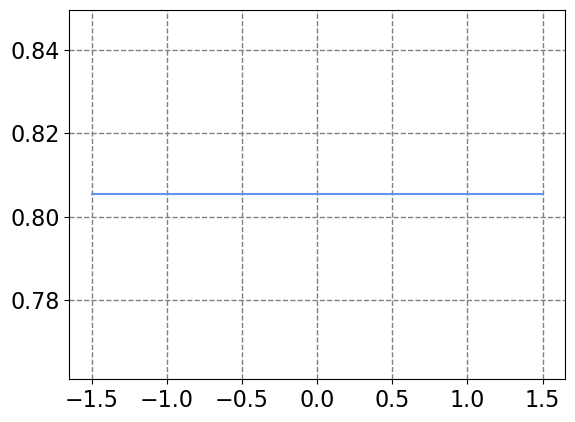

In [10]:
first_order_const_leakage = const_f1 + const_f2
print(f"Constant Leakage in first order component is {first_order_const_leakage}")

plt.plot(x_values, first_order_const_leakage*np.ones(100), color='cornflowerblue')
plt.grid('on')
plt.show()

This is the amount of constant leakage in first-order, i.e. the amount of constant in first-order terms which should be in the constant.

In [12]:
# --- Combine the total leakage from first order terms into f12 ---
f12_no_f1_leakage = f12_vals + f1_norm_zero_centred
f2_col = f2_norm_zero_centred[:, np.newaxis]
f12_no_first_order_leakage = f12_no_f1_leakage + f2_col

f12_const_leakage = f12_no_first_order_leakage - f12_true

In [13]:
mat = np.zeros((100,100))
first_order_leakage_into_f12 = mat + f1_norm_zero_centred + f2_col 

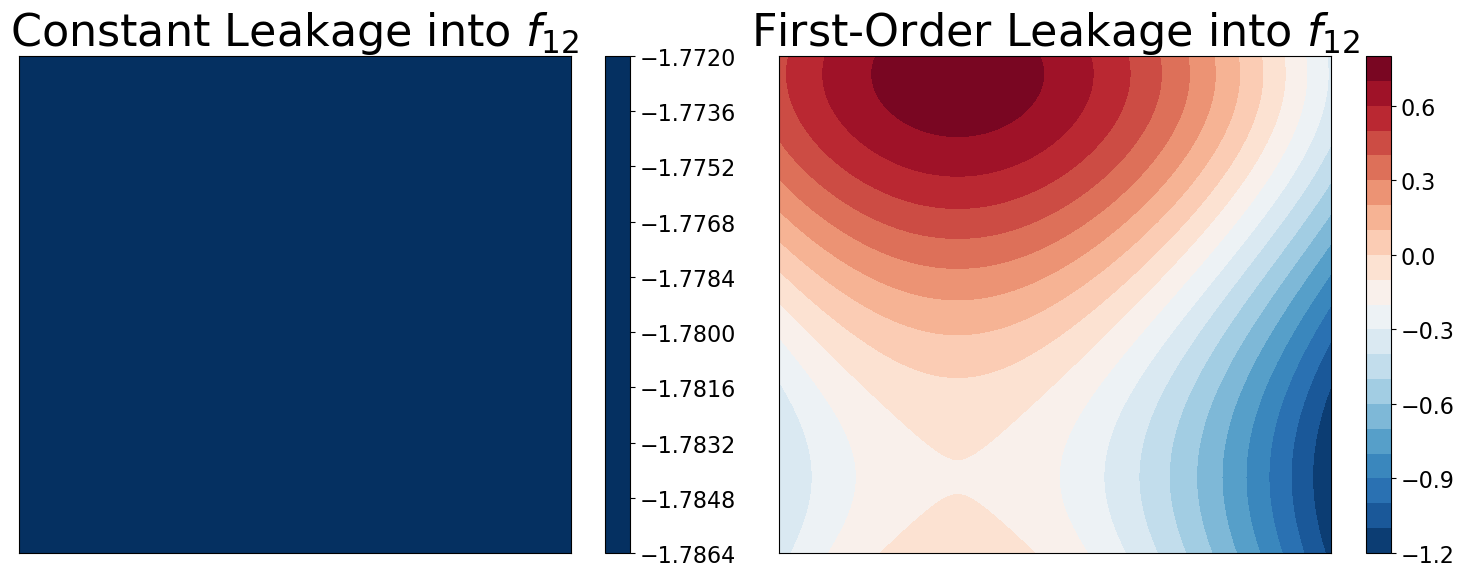

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

cont = axes[0].contourf(X1_grid, X2_grid, f12_const_leakage, levels=20, cmap='RdBu_r', vmin=-1, vmax=0)
axes[0].set_title("Constant Leakage into $f_{12}$")
fig.colorbar(cont, ax=axes[0])
axes[0].set_xticks([])
axes[0].set_yticks([])

cont = axes[1].contourf(X1_grid, X2_grid, first_order_leakage_into_f12, levels=20, cmap='RdBu_r')
axes[1].set_title("First-Order Leakage into $f_{12}$")
fig.colorbar(cont, ax=axes[1])
axes[1].set_xticks([])
axes[1].set_yticks([])

plt.tight_layout()
plt.show()

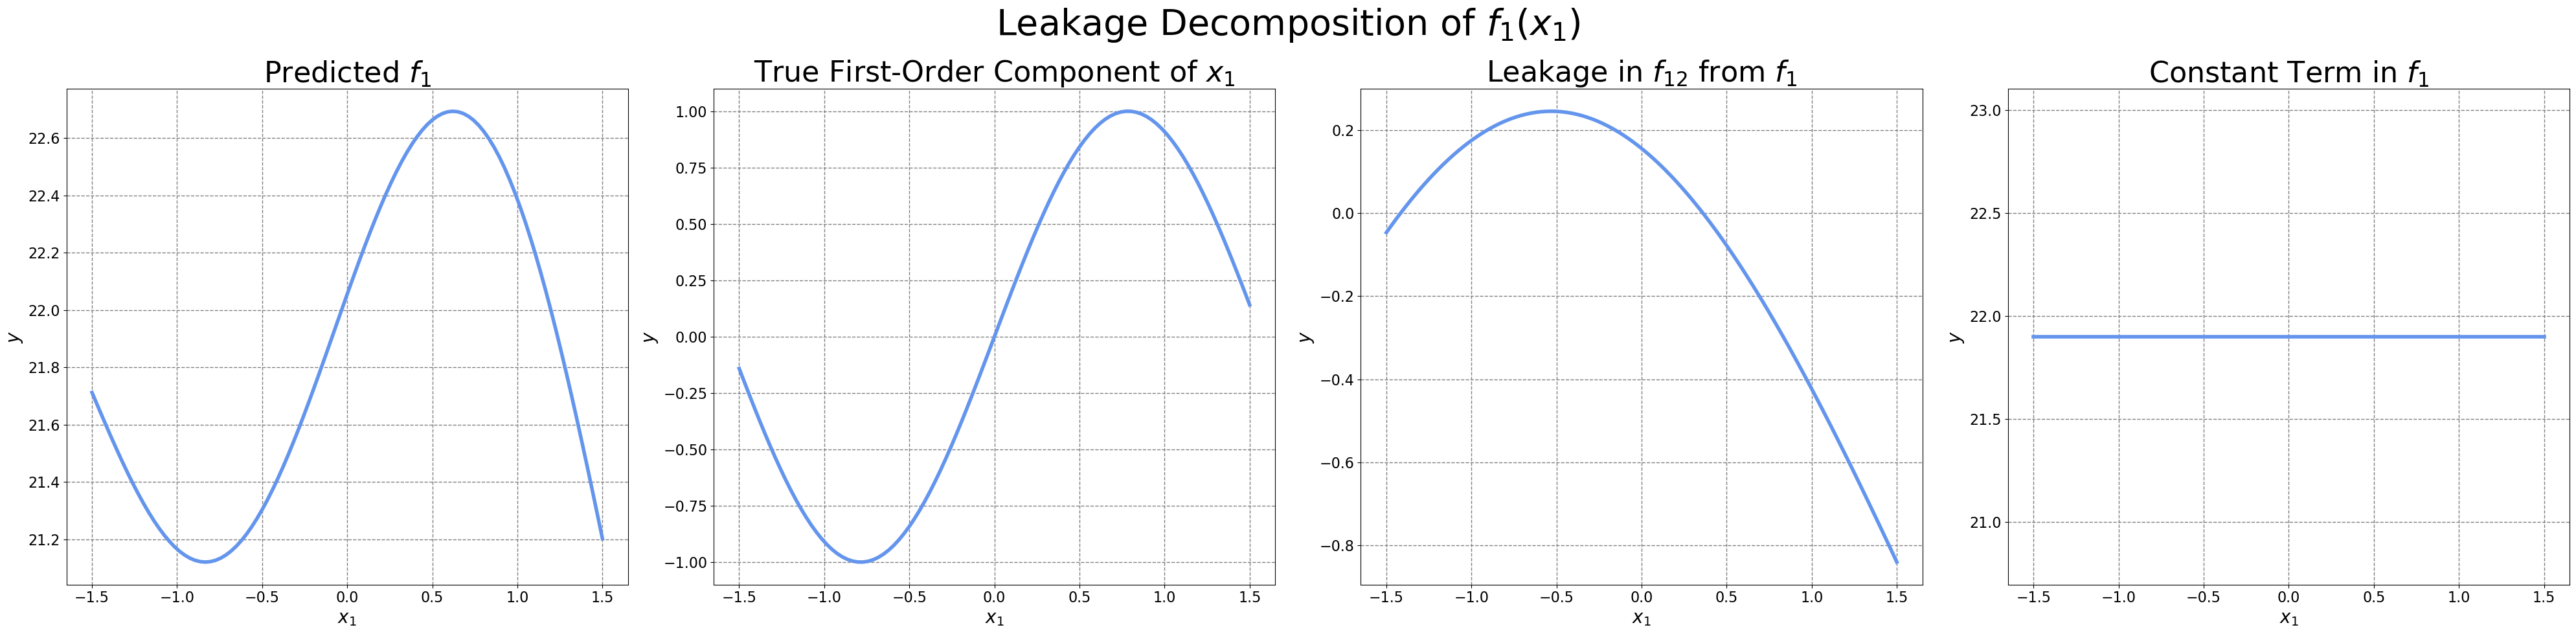

In [15]:
fig, axes = plt.subplots(1, 4, figsize=(40, 10))

# Predicted f1
axes[0].plot(x1_plot, f1_true + f1_norm_zero_centred + np.ones(100)*const_f1, color='cornflowerblue', linewidth=4)
axes[0].set_title("Predicted $f_1$")
axes[0].set_xlabel('$x_1$')
axes[0].set_ylabel('$y$')
axes[0].grid(True)


# Ground Truth
axes[1].plot(x1_plot, f1_true, color='cornflowerblue', linewidth=4)
axes[1].set_title("True First-Order Component of $x_1$")
axes[1].set_xlabel('$x_1$')
axes[1].set_ylabel('$y$')
axes[1].grid(True)


# Leakage from f1 into f12
axes[2].plot(x1_plot, f1_norm_zero_centred, color='cornflowerblue', linewidth=4)
axes[2].set_title("Leakage in $f_{12}$ from $f_1$")
axes[2].set_xlabel('$x_1$')
axes[2].set_ylabel('$y$')
axes[2].grid(True)


# Constant Leakage
axes[3].plot(x1_plot, np.ones(100)*const_f1, color='cornflowerblue', linewidth=4)
axes[3].set_title("Constant Term in $f_1$")
axes[3].set_xlabel('$x_1$')
axes[3].set_ylabel('$y$')
axes[3].grid(True)

fig.suptitle('Leakage Decomposition of $f_1(x_1)$', fontsize=40)
plt.tight_layout()
plt.show()

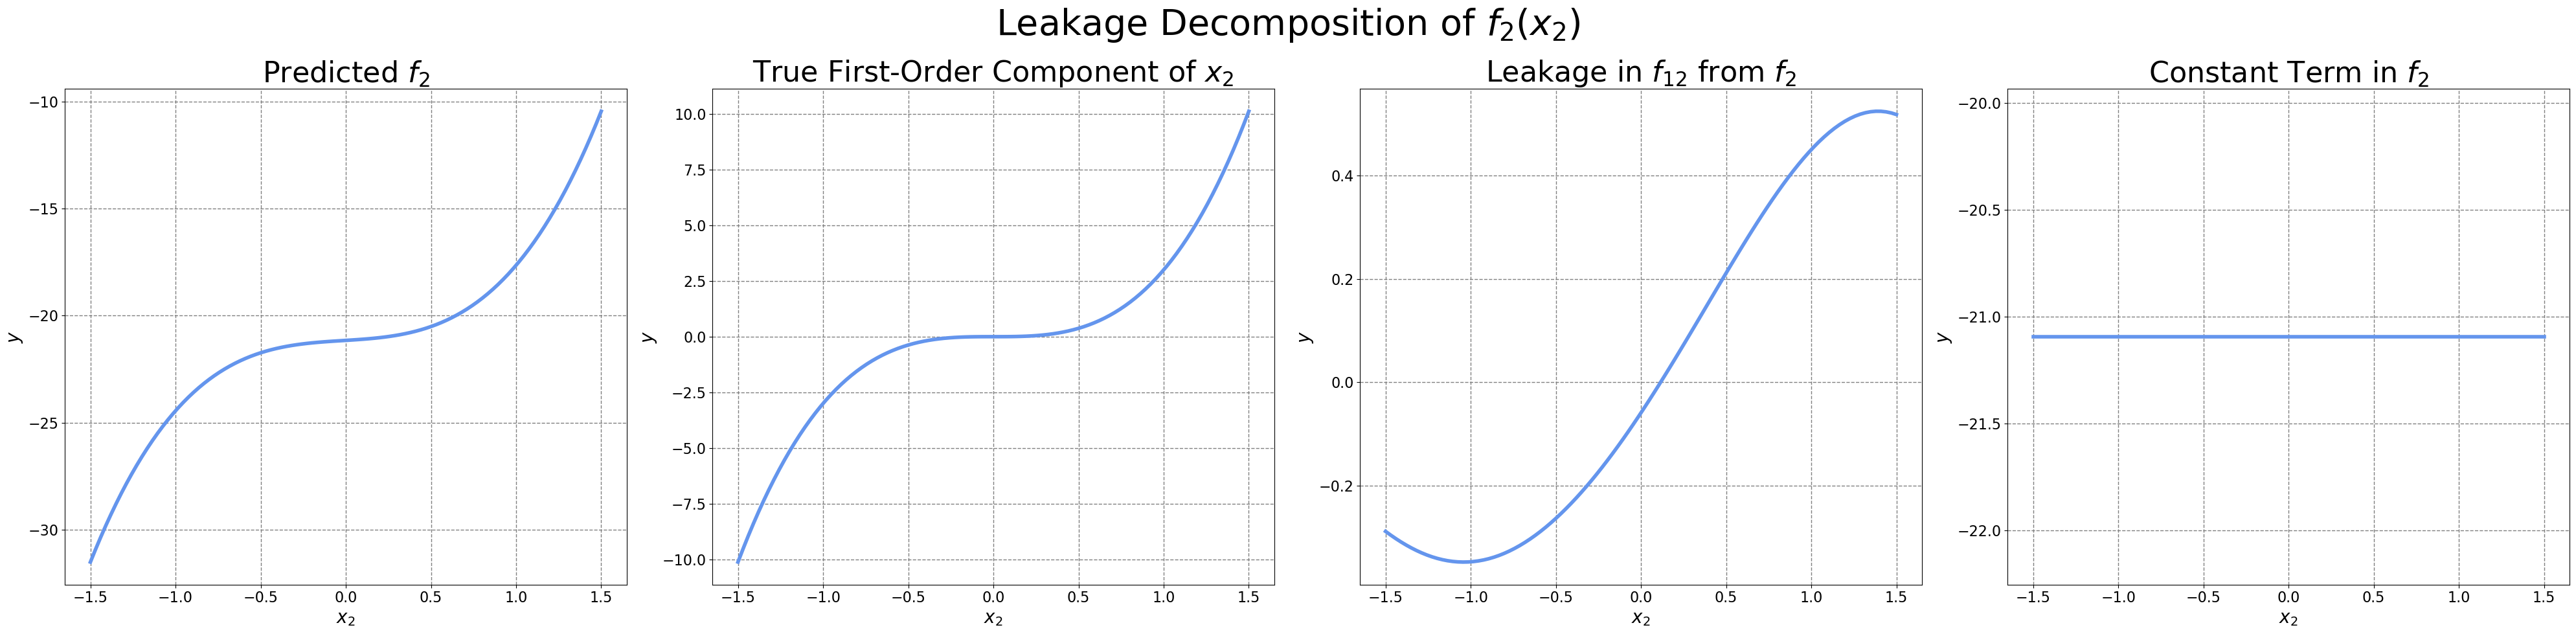

In [16]:
fig, axes = plt.subplots(1, 4, figsize=(40, 10))

# Predicted f2
axes[0].plot(x2_plot, f2_true + f2_norm_zero_centred + np.ones(100)*const_f2, color='cornflowerblue', linewidth=4)
axes[0].set_title("Predicted $f_2$")
axes[0].set_xlabel('$x_2$')
axes[0].set_ylabel('$y$')
axes[0].grid(True)


# Ground Truth
axes[1].plot(x2_plot, f2_true, color='cornflowerblue', linewidth=4)
axes[1].set_title("True First-Order Component of $x_2$")
axes[1].set_xlabel('$x_2$')
axes[1].set_ylabel('$y$')
axes[1].grid(True)


# Leakage from f2 into f12
axes[2].plot(x2_plot, f2_norm_zero_centred, color='cornflowerblue', linewidth=4)
axes[2].set_title("Leakage in $f_{12}$ from $f_2$")
axes[2].set_xlabel('$x_2$')
axes[2].set_ylabel('$y$')
axes[2].grid(True)


# Constant Leakage
axes[3].plot(x2_plot, np.ones(100)*const_f2, color='cornflowerblue', linewidth=4)
axes[3].set_title("Constant Term in $f_2$")
axes[3].set_xlabel('$x_2$')
axes[3].set_ylabel('$y$')
axes[3].grid(True)

fig.suptitle('Leakage Decomposition of $f_2(x_2)$', fontsize=40)
plt.tight_layout()
plt.show()

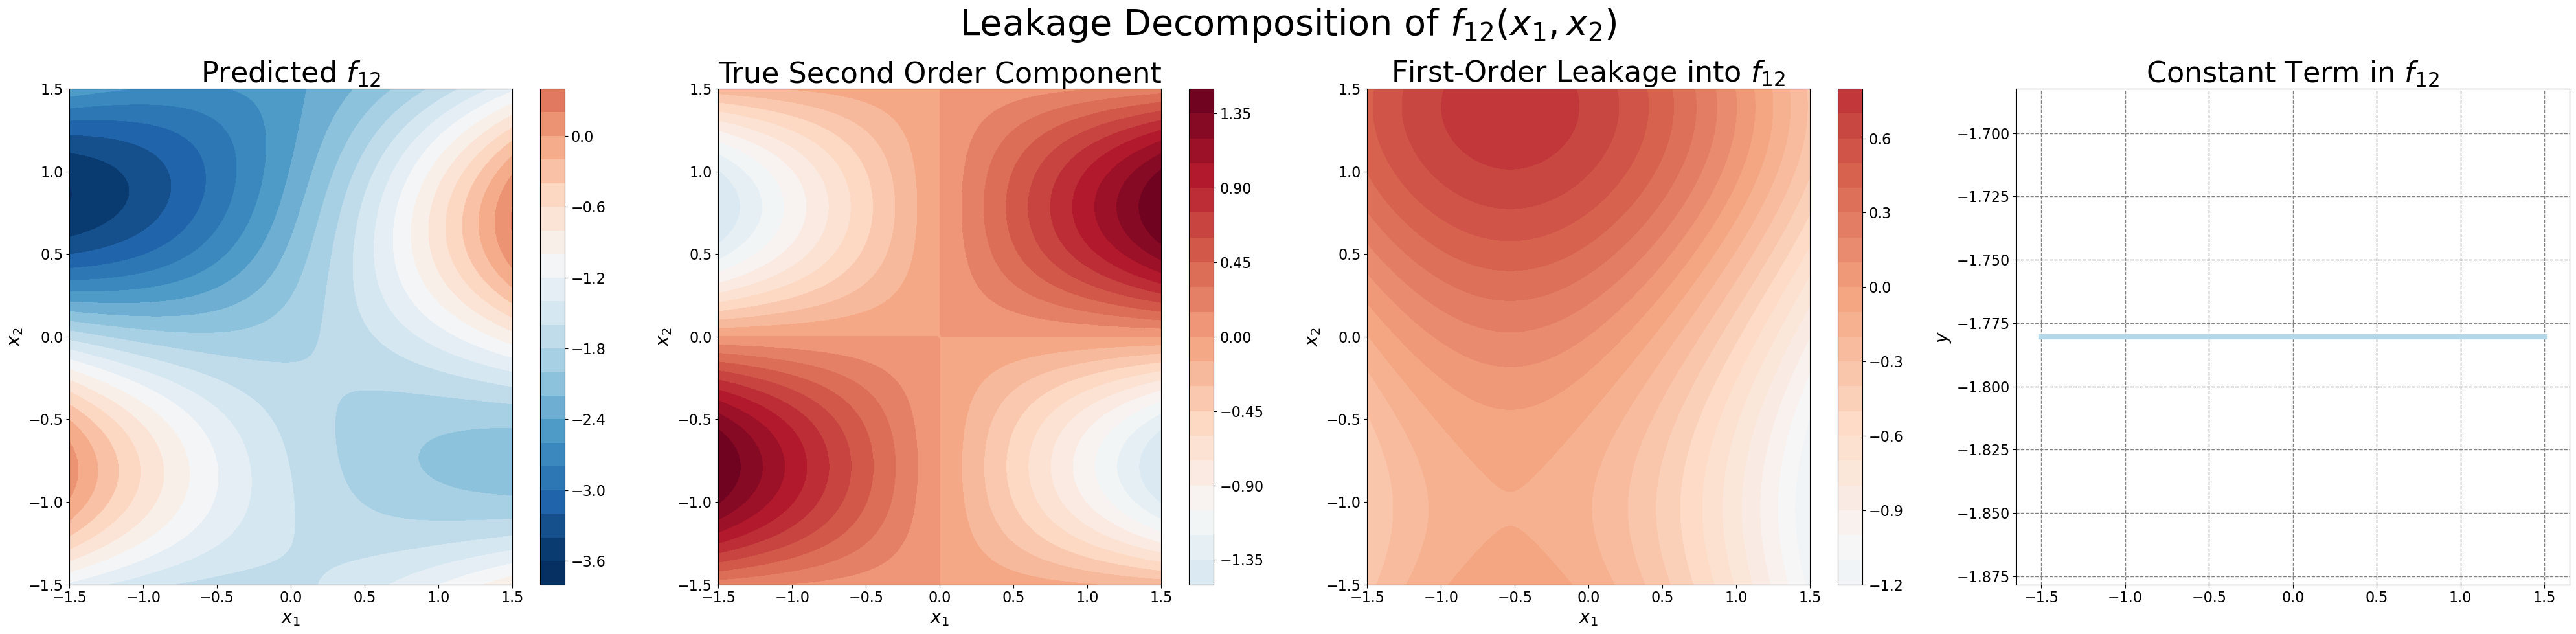

In [17]:
fig, axes = plt.subplots(1, 4, figsize=(40, 10))

vmin = np.min([f12_const_leakage + f12_true - first_order_leakage_into_f12, f12_true, first_order_leakage_into_f12])
vmax = np.max([f12_const_leakage + f12_true - first_order_leakage_into_f12, f12_true, first_order_leakage_into_f12])

# Predicted f12
cont = axes[0].contourf(X1_grid, X2_grid, f12_const_leakage + f12_true - first_order_leakage_into_f12, levels=20, cmap='RdBu_r', vmin=vmin, vmax=vmax)
axes[0].set_title("Predicted $f_{12}$")
fig.colorbar(cont, ax=axes[0])
axes[0].set_xlabel('$x_1$')
axes[0].set_ylabel('$x_2$')


# Ground Truth
cont = axes[1].contourf(X1_grid, X2_grid, f12_true, levels=20, cmap='RdBu_r', vmin=vmin, vmax=vmax)
axes[1].set_title("True Second Order Component")
fig.colorbar(cont, ax=axes[1])
axes[1].set_xlabel('$x_1$')
axes[1].set_ylabel('$x_2$')



# Leakage from f1 into f12
cont = axes[2].contourf(X1_grid, X2_grid, first_order_leakage_into_f12, levels=20, cmap='RdBu_r', vmin=vmin, vmax=vmax)
axes[2].set_title("First-Order Leakage into $f_{12}$")
fig.colorbar(cont, ax=axes[2])
axes[2].set_xlabel('$x_1$')
axes[2].set_ylabel('$x_2$')

norm = Normalize(vmin=vmin, vmax=vmax)
cmap = plt.get_cmap('RdBu_r')
rgba_color = cmap(norm(np.mean(f12_const_leakage)))

# Constant Leakage
axes[3].plot(x2_plot, np.ones(100)*np.mean(f12_const_leakage), color=rgba_color, linewidth=6)
axes[3].set_title("Constant Term in $f_{12}$")
#axes[3].set_xlabel('$x_1$')
axes[3].set_ylabel('$y$')
axes[3].grid(True)

fig.suptitle('Leakage Decomposition of $f_{12}(x_1, x_2)$', fontsize=40)
plt.tight_layout()
plt.show()

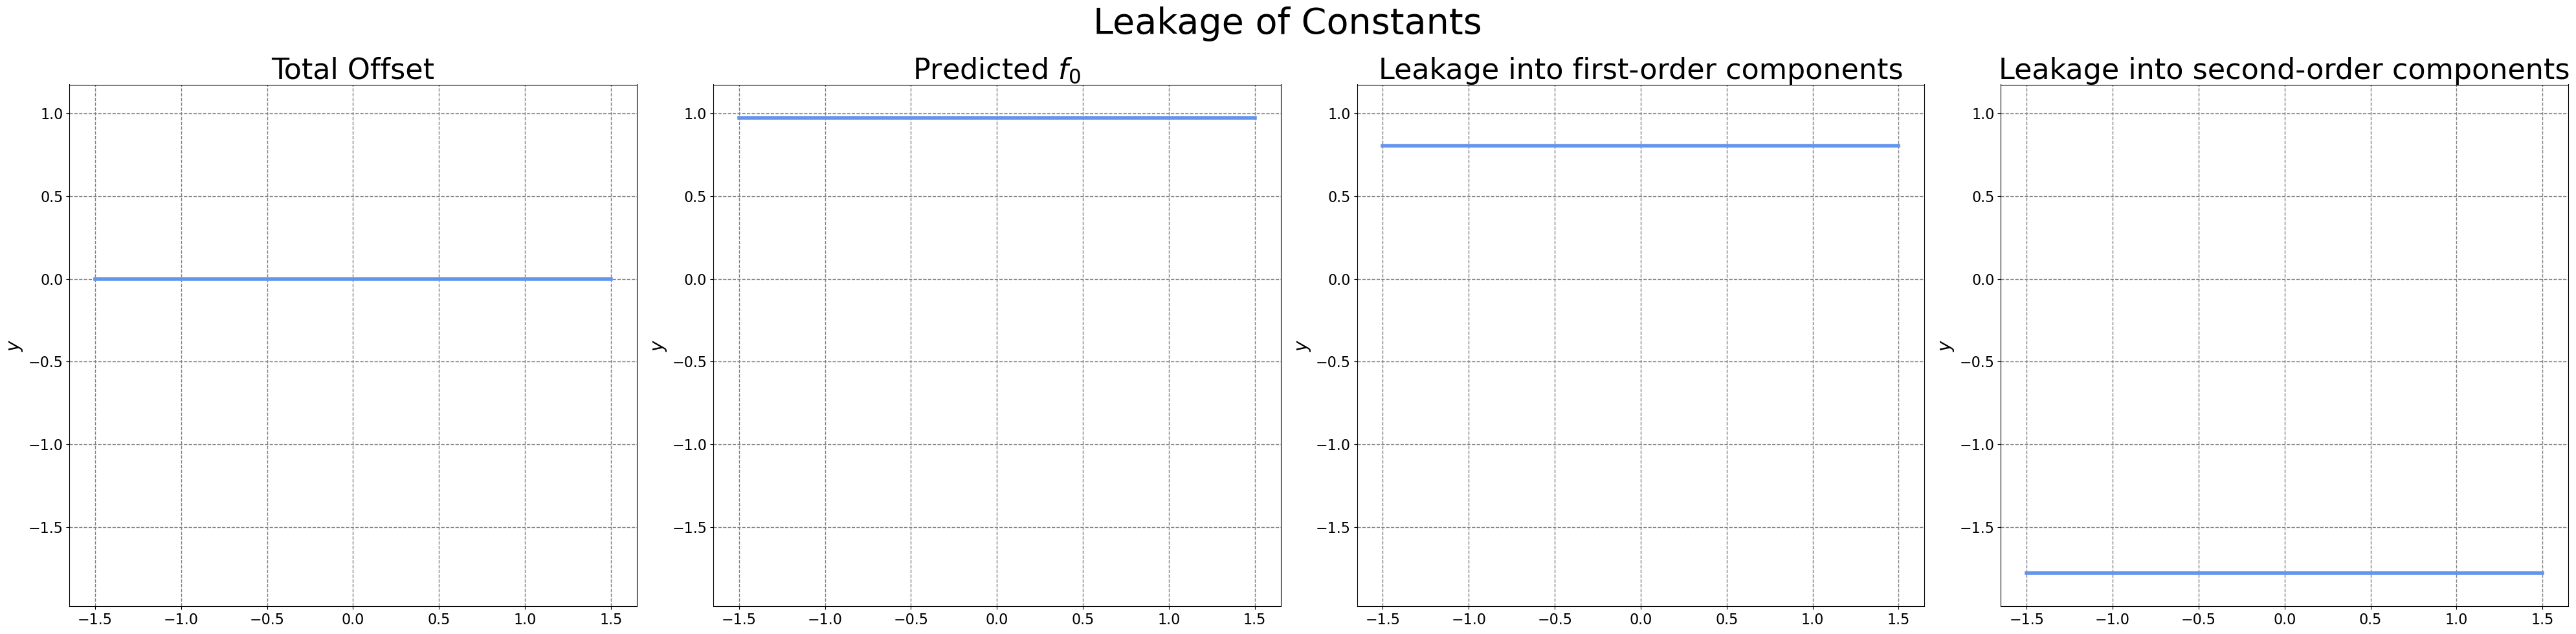

In [18]:
fig, axes = plt.subplots(1, 4, figsize=(40, 10))

vmin = min(f0_vals[0][0], const_f1 + const_f2, np.mean(f12_const_leakage)) - 0.2
vmax = max(f0_vals[0][0], const_f1 + const_f2, np.mean(f12_const_leakage)) + 0.2

# Predicted constant
axes[0].plot(x2_plot, np.ones(100)*(f0_vals[0][0] + const_f1 + const_f2 + np.mean(f12_const_leakage)), color='cornflowerblue', linewidth=4)
axes[0].set_title("Total Offset")
axes[0].set_ylim([vmin,vmax])
axes[0].set_ylabel('$y$')
axes[0].grid(True)

# Predicted constant 
axes[1].plot(x2_plot, np.ones(100)*(f0_vals[0][0]) , color='cornflowerblue', linewidth=4)
axes[1].set_title("Predicted $f_0$")
axes[1].set_ylim([vmin,vmax])
axes[1].set_ylabel('$y$')
axes[1].grid(True)


# Net first-order constant
axes[2].plot(x2_plot, np.ones(100)*(const_f1 + const_f2), color='cornflowerblue', linewidth=4)
axes[2].set_title("Leakage into first-order components")
axes[2].set_ylim([vmin,vmax])
axes[2].set_ylabel('$y$')
axes[2].grid(True)


# Second-order constant
axes[3].plot(x2_plot, np.ones(100)*np.mean(f12_const_leakage), color='cornflowerblue', linewidth=4)
axes[3].set_title("Leakage into second-order components")
axes[3].set_ylim([vmin,vmax])
axes[3].set_ylabel('$y$')
axes[3].grid(True)

fig.suptitle('Leakage of Constants', fontsize=40)
plt.tight_layout()
plt.show()

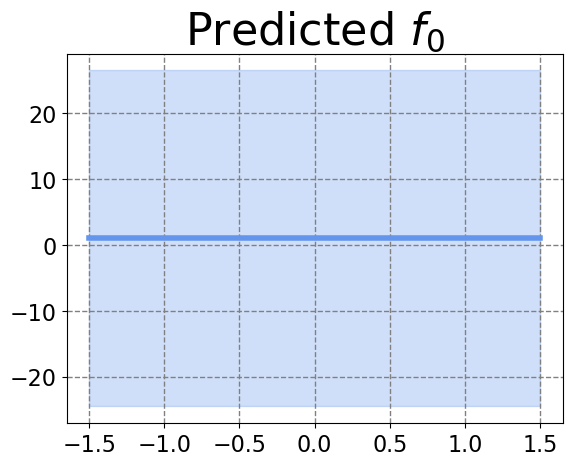

In [19]:
plt.plot(x2_plot, np.ones(100)*(f0_vals[0][0]) , color='cornflowerblue', linewidth=4)
plt.fill_between(x2_plot, np.ones(100)*(f0_vals[0][0]) - 2*std_f0[0][0]*np.ones(100), np.ones(100)*(f0_vals[0][0]) + 2*std_f0[0][0]*np.ones(100), color='cornflowerblue', alpha=0.3)
plt.title("Predicted $f_0$")
plt.grid(True)

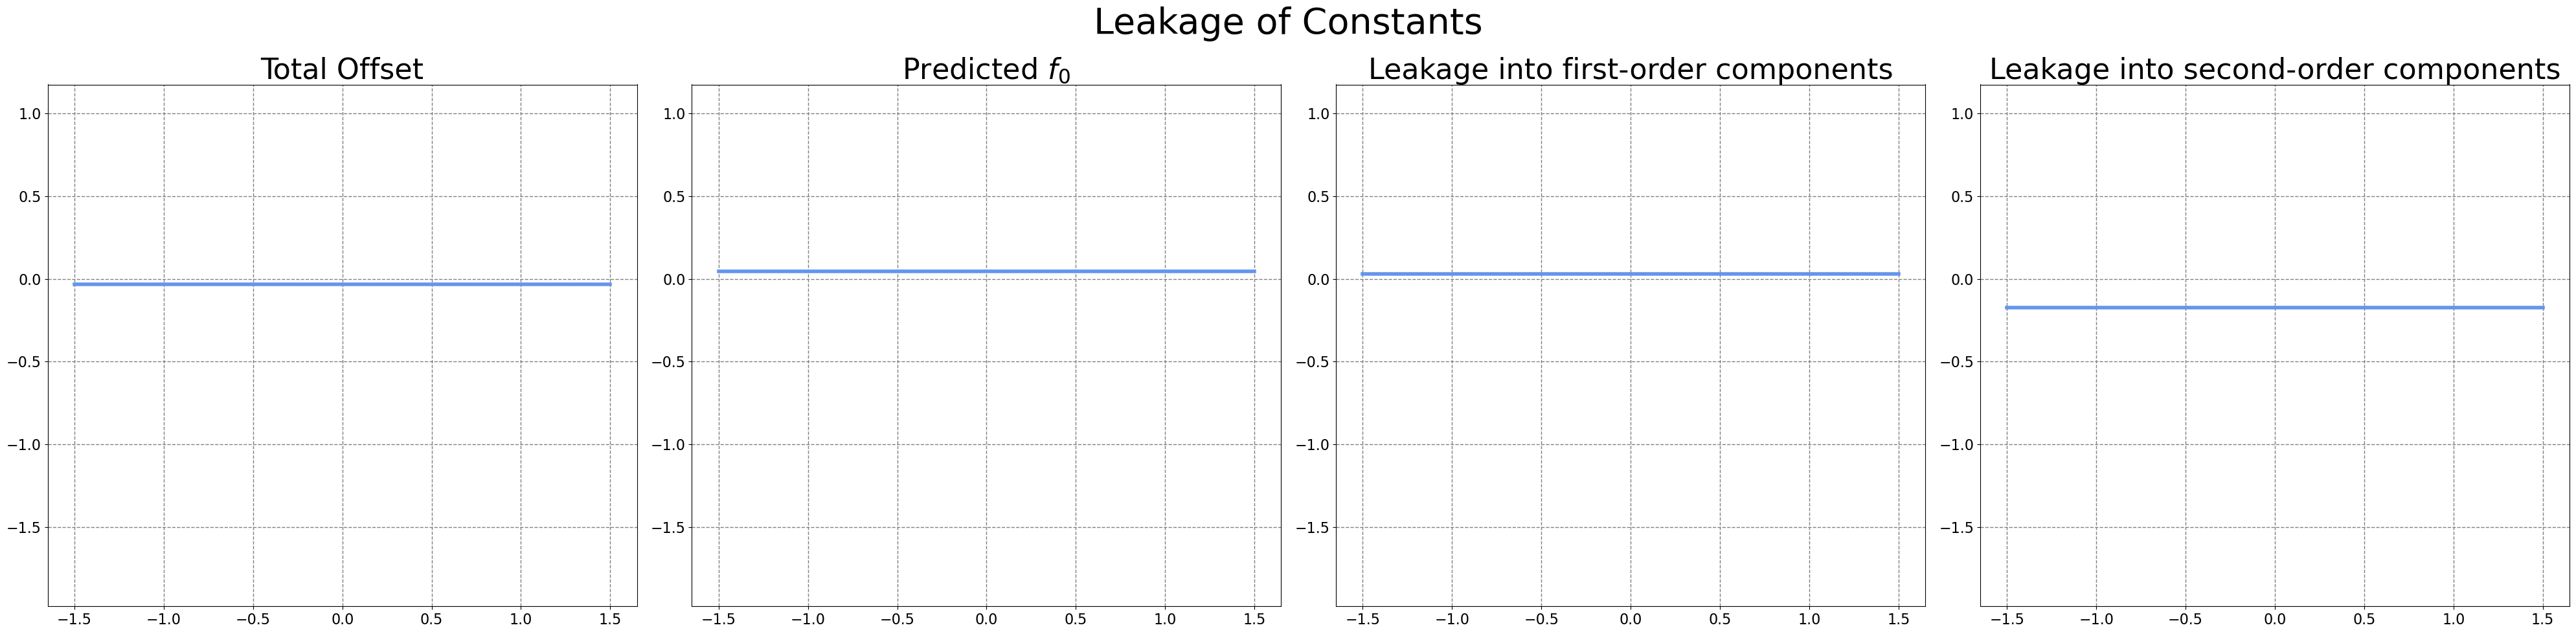

In [20]:
fig, axes = plt.subplots(1, 4, figsize=(40, 10))

vmin = min(f0_vals[0][0], const_f1 + const_f2, np.mean(f12_const_leakage)) - 0.2
vmax = max(f0_vals[0][0], const_f1 + const_f2, np.mean(f12_const_leakage)) + 0.2

# Predicted constant
axes[0].plot(x2_plot, np.ones(100)*((f0_vals[0][0] + const_f1 + const_f2 + np.mean(f12_const_leakage))-y_mean)/y_std, color='cornflowerblue', linewidth=4)
axes[0].set_title("Total Offset")
axes[0].set_ylim([vmin,vmax])
axes[0].grid(True)

# Predicted constant 
axes[1].plot(x2_plot, np.ones(100)*((f0_vals[0][0])-y_mean)/y_std , color='cornflowerblue', linewidth=4)
axes[1].set_title("Predicted $f_0$")
axes[1].set_ylim([vmin,vmax])
axes[1].grid(True)


# Net first-order constant
axes[2].plot(x2_plot, np.ones(100)*((const_f1 + const_f2)-y_mean)/y_std, color='cornflowerblue', linewidth=4)
axes[2].set_title("Leakage into first-order components")
axes[2].set_ylim([vmin,vmax])
axes[2].grid(True)


# Second-order constant
axes[3].plot(x2_plot, np.ones(100)*(np.mean(f12_const_leakage)-y_mean)/y_std, color='cornflowerblue', linewidth=4)
axes[3].set_title("Leakage into second-order components")
axes[3].set_ylim([vmin,vmax])
axes[3].grid(True)

fig.suptitle('Leakage of Constants', fontsize=40)
plt.tight_layout()
plt.show()